## CNN Fashion Mnist 95% Accuracy


Hello! This is my very first external dataset model that I created a few months ago - Just starting out in ML

## Basic fashion Mnist model
- Before I start, I did **NOT** use tensorflow's inbuilt fashion mnist dataset.
- I created this notebook for a 24 hour competition, and decided to use Fashion Mnist as a dataset.
- Going to convert this code into pytorch and improve it in pytorch, as I found more affection towards the framework.


**Agenda:**
- Model Params
- Create Dataset
- Augmentations
- Aux functions
- Training loop and testing

## Model Params

In [1]:
import math, os, re, warnings, random, time
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import KFold
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras import optimizers, Sequential, losses, metrics, Model
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.utils import to_categorical



from keras.preprocessing.image import ImageDataGenerator

def seed_everything(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

seed = 0
seed_everything(seed)
warnings.filterwarnings('ignore')

In [2]:
#Variables
AUTO = tf.data.experimental.AUTOTUNE

BATCH_SIZE = 128
LEARNING_RATE = 1e-8
EPOCHS = 10
HEIGHT = 28
WIDTH = 28
HEIGHT_RS = 28
WIDTH_RS = 28
CHANNELS = 1
N_CLASSES = 9
N_FOLDS = 5
FOLDS_USED = 5
ES_PATIENCE = 5

In [3]:
import numpy as np 
import pandas as pd 

import os
for dirname, _, filenames in os.walk('../input/fashionmnist'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/fashionmnist/t10k-labels-idx1-ubyte
../input/fashionmnist/t10k-images-idx3-ubyte
../input/fashionmnist/fashion-mnist_test.csv
../input/fashionmnist/fashion-mnist_train.csv
../input/fashionmnist/train-labels-idx1-ubyte
../input/fashionmnist/train-images-idx3-ubyte


## Load data

Train samples: 60000
train missing values: 0
test missing values: 0
(60000, 785)
(10000, 785)
<class 'pandas.core.frame.DataFrame'>


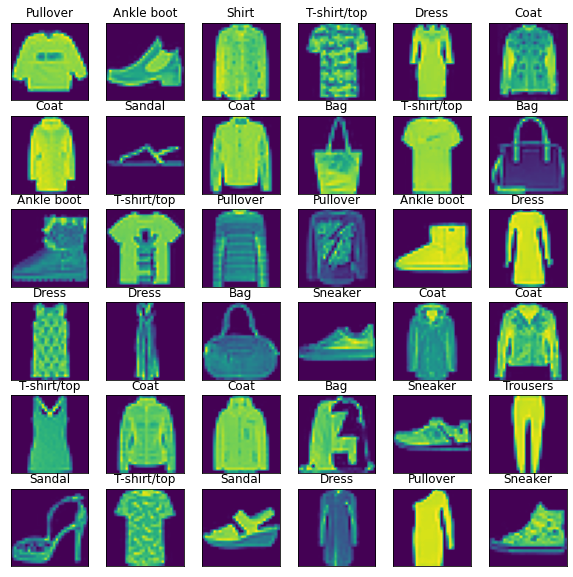

In [4]:
def count_data_items(filenames):
    n = [int(re.compile(r'-([0-9]*)\.').search(filename).group(1)) for filename in filenames]
    return np.sum(n)

data_base_path = "../input/fashionmnist/"
train = pd.read_csv(f'{data_base_path}fashion-mnist_train.csv')
test = pd.read_csv(f'{data_base_path}fashion-mnist_test.csv')

print(f'Train samples: {len(train)}')

print("train missing values:", train.isnull().any().sum())
print("test missing values:", test.isnull().any().sum())



TRAIN_IMAGES = train.copy()
TEST_IMAGES = test.copy()

print(TRAIN_IMAGES.shape)
print(TEST_IMAGES.shape)
# NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
# print(f'GCS: train images: {NUM_TRAINING_IMAGES}')
print(type(TRAIN_IMAGES))


CLASSES = ['T-shirt/top', 
           'Trousers', 
           'Pullover', 
           'Dress', 'Coat', 
           'Sandal', 
           'Shirt', 
           'Sneaker', 
           'Bag', 
           'Ankle boot']

X = TRAIN_IMAGES.iloc[:,1:]
Y = TRAIN_IMAGES.iloc[:,0] 
plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X.loc[i].values.reshape((28,28))) #calling the .values of each row
    label_index = int(Y[i]) #setting as an int as the number is stored as a string
    plt.title(CLASSES[label_index])
plt.show()

In [5]:
# def converting(image):
#     img = tf.image.convert_image_dtype(img, dtype=tf.float32) / 255.0
#     return image

initial_fold = StratifiedKFold(n_splits = 4, random_state =1, shuffle = True)

for train_index, test_index in initial_fold. split(X, Y):
    TRAIN_IMAGES, TRAIN_VAL = X.iloc[train_index], X.iloc[test_index]
    TEST_IMAGES, TEST_VAL = Y[train_index], Y[test_index]
    
TRAIN_IMAGES =TRAIN_IMAGES.values.reshape(-1, HEIGHT,WIDTH,1)
TRAIN_VAL =TRAIN_VAL.values.reshape(-1, HEIGHT,WIDTH,1)




TEST_IMAGES = to_categorical(TEST_IMAGES, num_classes=10)
TEST_VAL = to_categorical(TEST_VAL, num_classes=10)

print("Train image shape: ", TRAIN_IMAGES.shape)
print("Train Val shape: ", TRAIN_VAL.shape)
print("Test image shape: ", TEST_IMAGES.shape)
print("Test  Val shape: ", TEST_VAL.shape)

Train image shape:  (45000, 28, 28, 1)
Train Val shape:  (15000, 28, 28, 1)
Test image shape:  (45000, 10)
Test  Val shape:  (15000, 10)


## Augmentations

In [6]:
def data_augment(image):
    p_spatial = tf.random.uniform([], 0, 1.0, dtype=tf.float32)
#     train_datagen = ImageDataGenerator(rescale=1./255)
    image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_flip_up_down(image)
    
#     if p_spatial > .75:
#         image = tf.image.transpose(image)
#     image = tf.image.rot90(image, k = 3)
#     datagen.fit(image)
    
    return image

## Auxiliary functions

In [7]:
def scale_image(image):
    """
        Cast tensor to float and normalizes (range between 0 and 1).
    """
#     image = tf.reshape(image, [28, 28, 1])
    image = tf.cast(image, tf.float32)
    image /= 255.0
#     image = tf.cast(image, tf.float32) / 255
    
    return image
# TRAIN_IMAGES = np.asarray(TRAIN_IMAGES).astype('float32')

# dataset = tf.data.Dataset.from_tensor_slices(TRAIN_IMAGES)
# dataset = dataset.map(scale_image, num_parallel_calls=AUTO)
    


def get_dataset(FILENAMES, ordered = False, repeated = False, cached = False, augment = False):
    
    if augment:
        FILENAMES = data_augment(FILENAMES)
        
#     FILENAMES = scale_image(FILENAMES)
    return FILENAMES



## Get Augmentations

In [8]:
TRAIN_IMAGES = get_dataset(TRAIN_IMAGES, ordered=True, augment=True)

# print(TRAIN_IMAGES.shape)
# print(TRAIN_VAL.shape)

# print(TRAIN_IMAGES[0].shape)

## Training

In [9]:
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense,Flatten,Dropout,Conv2D,MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, Callback, ModelCheckpoint

# Merge inputs and targets
inputs = np.concatenate((TRAIN_IMAGES, TRAIN_VAL), axis=0)
targets = np.concatenate((TEST_IMAGES, TEST_VAL), axis=0)
acc_per_fold = []
loss_per_fold = []

# Define the K-fold Cross Validator
kfold = KFold(n_splits=5, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                  data_format='channels_last', input_shape=(28,28,1)))
  model.add(BatchNormalization())

  model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                  data_format='channels_last'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                  data_format='channels_last'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
      
      
  model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', strides=1, padding='same', 
                  data_format='channels_last'))
  model.add(BatchNormalization())
  model.add(Dropout(0.25))

  model.add(Flatten())
  model.add(Dense(512, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(128, activation='relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(10, activation='softmax'))


  early_stopping_callback = EarlyStopping(monitor='val_loss', 
  #                                         min_delta=1e-2,
                                          patience=4,
                                          verbose = 1,
                                          restore_best_weights=True)

  ckpt = ModelCheckpoint(
          f'modelcheck{fold_no}.hdf5',
          verbose=1,
          save_best_only=True,
          save_weights_only=True
      )
  optimizer = Adam(lr=1e-3, beta_1=0.9, beta_2=0.999 )

  model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])

  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  history = model.fit(TRAIN_IMAGES,TEST_IMAGES,
                  batch_size=128,
                  epochs=10,
                  validation_data=(TRAIN_VAL,TEST_VAL),
  #                  validation_steps = TRAIN_VAL.shape[0] // 64,
                  verbose=1,
                  callbacks = [early_stopping_callback,ckpt])  
  scores = model.evaluate(TRAIN_VAL, TEST_VAL)
#   model.save('model.h5')
  scores = model.evaluate(inputs[test], targets[test], verbose=0)
 
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no = fold_no + 1  

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
352/352 [==============================] - ETA: 0s - loss: 0.5714 - accuracy: 0.8053
Epoch 00001: val_loss improved from inf to 0.32570, saving model to modelcheck1.hdf5
352/352 [==============================] - 8s 22ms/step - loss: 0.5714 - accuracy: 0.8053 - val_loss: 0.3257 - val_accuracy: 0.8839
Epoch 2/10
352/352 [==============================] - ETA: 0s - loss: 0.3489 - accuracy: 0.8778
Epoch 00002: val_loss improved from 0.32570 to 0.29867, saving model to modelcheck1.hdf5
352/352 [==============================] - 7s 21ms/step - loss: 0.3489 - accuracy: 0.8778 - val_loss: 0.2987 - val_accuracy: 0.8931
Epoch 3/10
349/352 [============================>.] - ETA: 0s - loss: 0.2915 - accuracy: 0.8988
Epoch 00003: val_loss improved from 0.29867 to 0.25229, saving model to modelcheck1.hdf5
352/352 [==============================] - 7s 20ms/step - loss: 0.2915 - accuracy: 0.898

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


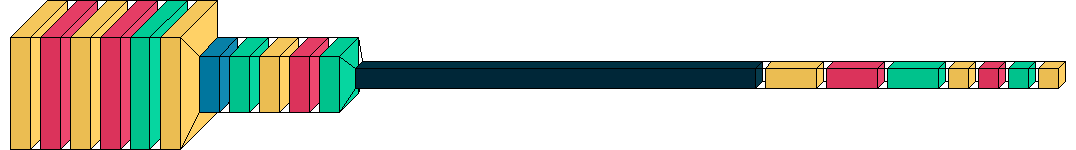

In [10]:
!pip install visualkeras
import visualkeras

visualkeras.layered_view(model)


## Evaluation

(15000, 28, 28, 1)


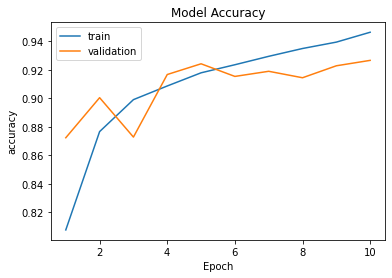

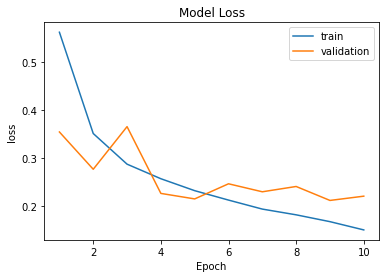

In [11]:
print(TRAIN_VAL.shape)
plt.title('Model Accuracy')
plt.plot(range(1,11),history.history['accuracy'])
plt.plot(range(1,11),history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(labels=['train','validation'])
plt.show()

plt.title('Model Loss')
plt.plot(range(1,11),history.history['loss'])
plt.plot(range(1,11),history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(labels=['train','validation'])
plt.show()


(15000, 28, 28, 1)


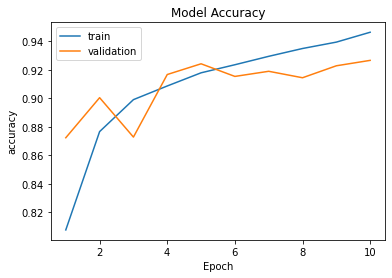

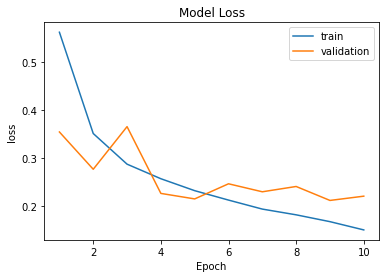

469/469 [==============================] - 1s 3ms/step - loss: 0.2209 - accuracy: 0.9266
Loss: 0.2209
Accuracy: 0.9266
------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 0.13641613721847534 - Accuracy: 95.09999752044678%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.12990902364253998 - Accuracy: 95.36666870117188%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.13375753164291382 - Accuracy: 95.23333311080933%
------------------------------------------------------------------------
> Fold 4 - Loss: 0.12587136030197144 - Accuracy: 95.52500247955322%
------------------------------------------------------------------------
> Fold 5 - Loss: 0.1274416148662567 - Accuracy: 95.74999809265137%
------------------------------------------------------------------------
Average scores f

In [12]:
print(TRAIN_VAL.shape)
plt.title('Model Accuracy')
plt.plot(range(1,11),history.history['accuracy'])
plt.plot(range(1,11),history.history['val_accuracy'])
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend(labels=['train','validation'])
plt.show()

plt.title('Model Loss')
plt.plot(range(1,11),history.history['loss'])
plt.plot(range(1,11),history.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend(labels=['train','validation'])
plt.show()


score = model.evaluate(TRAIN_VAL, TEST_VAL)

print('Loss: {:.4f}'.format(score[0]))
print('Accuracy: {:.4f}'.format(score[1]))


print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

In [13]:
from itertools import *
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

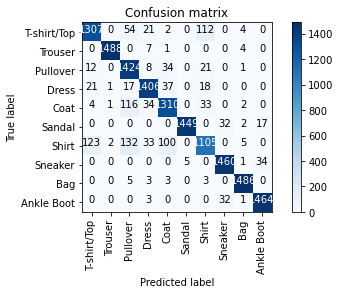

In [14]:
Y_pred = model.predict(TRAIN_VAL)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(TEST_VAL,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, 
            classes = ['T-shirt/Top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot'])

Text(0.5, 1.0, 'Predicted Label : Bag\nActual Label : Bag')

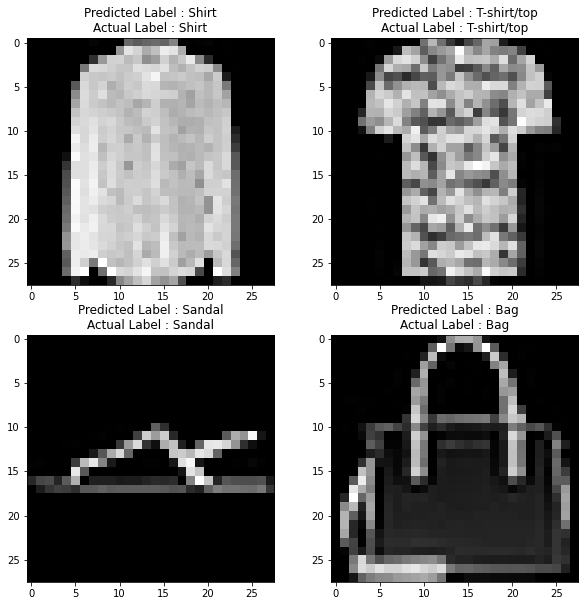

In [15]:
correct = []
for i in range(len(TEST_VAL)):
    if(Y_pred_classes[i] == Y_true[i]):
        correct.append(i)
    if(len(correct) == 4):
        break
TRAIN_VAL = np.array(TRAIN_VAL)

    
fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(TRAIN_VAL[correct[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[correct[0]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[correct[0]]]))
ax[0,1].imshow(TRAIN_VAL[correct[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[correct[1]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[correct[1]]]))
ax[1,0].imshow(TRAIN_VAL[correct[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[correct[2]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[correct[2]]]))
ax[1,1].imshow(TRAIN_VAL[correct[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[correct[3]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[correct[3]]]))

Text(0.5, 1.0, 'Predicted Label : Sneaker\nActual Label : Ankle boot')

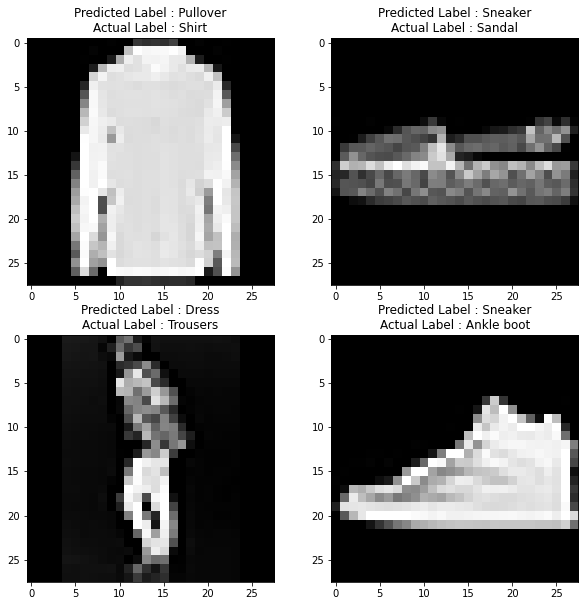

In [16]:
incorrect = []
for i in range(len(TEST_VAL)):
    if(not Y_pred_classes[i] == Y_true[i]):
        incorrect.append(i)
    if(len(incorrect) == 4):
        break

fig, ax = plt.subplots(2,2, figsize=(12,6))
fig.set_size_inches(10,10)
ax[0,0].imshow(TRAIN_VAL[incorrect[0]].reshape(28,28), cmap='gray')
ax[0,0].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[incorrect[0]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[incorrect[0]]]))
ax[0,1].imshow(TRAIN_VAL[incorrect[1]].reshape(28,28), cmap='gray')
ax[0,1].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[incorrect[1]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[incorrect[1]]]))
ax[1,0].imshow(TRAIN_VAL[incorrect[2]].reshape(28,28), cmap='gray')
ax[1,0].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[incorrect[2]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[incorrect[2]]]))
ax[1,1].imshow(TRAIN_VAL[incorrect[3]].reshape(28,28), cmap='gray')
ax[1,1].set_title("Predicted Label : " + str(CLASSES[Y_pred_classes[incorrect[3]]]) + "\n"+"Actual Label : " + 
                 str(CLASSES[Y_true[incorrect[3]]]))


## Custom Step size + TTA